### Tutorial de series temporais com LSTM
Neste notebook iremos configurar uma rede neural LSTM para prever series temporais. Estou tentando criar uma estrutura generica para que seja possivel testar diferentes tipos de abordagens de modelagem.

Este conjunto de dados possui informacoes sobre condicoes climaticas e poluicao do ar a cada 1 hora.

Colunas:


    No: row number
    year: year of data in this row
    month: month of data in this row
    day: day of data in this row
    hour: hour of data in this row
    pm2.5: PM2.5 concentration
    DEWP: Dew Point
    TEMP: Temperature
    PRES: Pressure
    cbwd: Combined wind direction
    Iws: Cumulated wind speed
    Is: Cumulated hours of snow
    Ir: Cumulated hours of rain

Faremos a previsao da poluicao de acordo com as condicoes climaticas e poluicao historica

Obs: por motivos de configuracao de teclado, nao utilizarei acentuacao neste notebook

### Organizacao inicial dos dados e analise exploratoria
Vamos iniciar carregando os dados do seguinte endereco: https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv

Lembrete: cada linha representa UMA HORA do dia na qual os dados foram coletados.

Em seguida iremos criar o campo data, substituir valores ausentes e remover algumas observacoes (primieras 24 horas ou registros) que nao possuem informacao sobre poluicao.

In [1]:
# Importa os pacotes
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# Funcao para formatar as datas
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

# Le o aquivo original e cria o campo data por meio da funcao parse
dataset = pd.read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

# Remove a coluna `No`
dataset.drop('No', axis=1, inplace=True)

# Altera o nome das colunas e define o novo indice do dataframe
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# Troca NA por zeros
dataset['pollution'].fillna(0, inplace=True)

# As primeiras 24 linhas (horas) do conjunto de dados nao possui valor para a variavel `poluicao`.
# Por este motivo iremos remover estas linhas
dataset = dataset[24:]

# Mostra as 5 primeiras linhas do dataframe
print(dataset.head(5))

# Salva os resultados em um novo arquivo
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


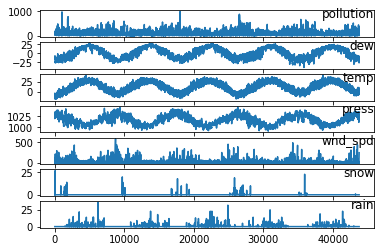

In [3]:
# Carrega o novo dataset
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# Especifica as colunas que aparecerao no grafico
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1

# Plota cada coluna
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

### Transformando os dados em serie estacionaria
Series estacionarias sao mais simples para modelagem. Series estacionarias sao aquelas que nao apresentam tendencia e nem sazonalidade.

Uma das formas mais utilizadas para remover tendencia e sazonalidade de uma serie temporal eh aplicando a transformacao de diferenciacao. Esta transformacao remove o valor de t-1 de t.

Agora vamos criar nossa funcao de diferenciacao, assim como a funcao para inverter a diferenciacao (ja que precisamos inverter os resultados antes de aprensetar os resultados finais do modelo).

In [4]:
# Cria a funcao de diferenciacao
def difference(y, interval=1):
    diff = list()
    for i in range(0, len(y)):
        value = y[i]
        if (i > 0):
            value = y[i] - y[i - interval]
        diff.append(value)
    return y,diff

# Cria a funcao para inverter a operacao de diferenciacao
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

### Preparando os dados para LSTM
Neste passo iremos preparar os dados para que sejam usados pela rede neural.
Basicamente precisamos das seguintes etapas (independente da ordem):
* um dataframe no formato (features, target)
* todas as variaveis devem ser numericas e na mesma escala


In [5]:
# Funcao para preparar os dados para aprendizagem supervisionada (features,target)
def series_to_supervised(data, index, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # Cria a sequencia de entrada - input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # Cria a sequencia de saida - forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # Junta os dados
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Set indexes
    agg.index = index
    
    # Remove valores ausentes
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Funcao para carregar os dados de treino
def load_training (n_in=1, n_out=1):
    
    # Carrega os dados
    dataset = pd.read_csv('pollution.csv', header=0, index_col=0)

    # Transforma dos dados em serie estacionaria
    raw_values_diff, pollution = difference(dataset['pollution'])
    dataset.drop('pollution', axis=1, inplace=True)
    dataset['pollution'] = pollution
    dataset = dataset [['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']]

    # Cria e utiliza um label encoder para transformar a coluna `wind` (string) em um numero (categoria)
    encoder = LabelEncoder()
    dataset['wnd_dir'] = encoder.fit_transform(dataset['wnd_dir'])

    # Garantindo que todos as colunas sao numericas
    dataset = dataset.apply(pd.to_numeric)

    # Transforma os dados para o formato que pode ser usado na modelagem (features, target)
    reframed = series_to_supervised(dataset, dataset.index, n_in, n_out)
    reframed['target_original'] = raw_values_diff
    reframed['fator_inverter_diff'] = reframed['target_original'] - reframed['var1(t)']
    return reframed

Note que a funcao `series_to_supervised` pode ser receber diferentes valores para os parametros n_in e n_out.
Para cada coluna do seu dataframe, esta funcao vai:
* calcular os time steps t-1, t-2, t-n (de acordo com o parametro n_in)
* calcular os time steps t0, t+1, t+n (de acordo com o parametro n_out)

Ou seja, podemos usar esta mesma funcao para diferentes problemas, como:
* univariate/multivariate
* one-step/multiple-stes

### Separando os dados entre treino e teste
Agora vamos separar os dados entre treino e teste. 
Este dataset possui 5 anos de informacoes. Usaremos 1 ano para treino e 4 anos para teste.

Caso tenha duvidas sobre a forma de funcionamento de arrays em Python, use a seguinte referencia:

array[range de linhas separado por :, range de colunas separado por :]

Sendo que se voce nao especificar nada, sera entendido como tudo/restante. Por exemplo:

train = values[:n_train_hours, :]
* Seleciona da linha 0 ate a linha `n_train_hours`
* Seleciona todas as colunas

train[:, :-1]
* Seleciona todas as linhas
* Seleciona todas as colunas, exceto a ultima

train[:, -1]
* Seleciona todas as linhas
* Seleciona a ultima coluna

In [6]:
# Divide os dados entre treino e teste
def split_train_test (reframed, registros_train=365*24, time_steps=1):
    values = reframed.values
    train = values[:registros_train, :]
    test = values[registros_train:, :]

    # Divide os dados entre entrada e saida
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # Ajusta o shape do dataframe para o formato esperado pela rede LSTM (3D) [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], time_steps, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    return train_X, train_y, test_X, test_y

### Definindo a rede neural e treinando o modelo

Vamos criar uma LSTM com 50 neurons na primeira camada e 1 neuron na camada de saida para prever a poluicao. O valor de input_shape sera 1 time step com 8 features.

Vamos usar Mean Absolute Error (MAE) como loss function e o treinamento sera feito usando o metodo Adam.

O modelo sera treinado com 50 epochs e batch size de 72. Lembrando que o estado interno da rede LSTM do Keras eh resetado a cada batch.

Note que a ultima camada da rede sera responsavel por fazer as previsoes. Se definirmos este camada com 1 neuron, significa que faremos a previsao de um periodo...2 neurons faz a previsao de 2 periodos...e assim por diante.

Outro detalhe eh que esta camada de saida nao possui funcao de ativacao. Isso porque nao queremos transformar a previsao em nenhuma escala (por exemplo, 0..1, etc). Qeremos apenas expor as previsoes de poluicao encontradas.
Eh comum usar funcoes de ativacao na camada de saida quando estamos trabalhando com modelos de classificacao (por exemplo, sigmoid function para modelos de classificacao binaria).

In [10]:
def execute_scenario (name, time_steps, seq, vars_to_use_time_step, vars_to_use_time_seq, min_scale, max_scale, n_train):

    print (name)

    # Carrega os dados de treino
    reframed = load_training (n_in=time_steps, n_out=seq)
    
    # Separa algumas colunas chaves
    target_original = reframed['target_original']
    fator_inverter_diff = reframed['fator_inverter_diff']
    index = reframed.index

    # Define quais variaveis serao utilizadas
    name_var_steps = []
    for i in range(1,time_steps+1):
        name_var_steps += [('var%d(t-%d)' % (j, i)) for j in vars_to_use_time_step]
    name_var_steps

    name_var_seqs = []
    for i in range(0,seq):
        if i == 0:
            name_var_seqs += [('var%d(t)' % (j)) for j in vars_to_use_time_seq]
        else:
            name_var_seqs += [('var%d(t+%d)' % (j, i)) for j in vars_to_use_time_seq]
    name_var_seqs

    names = name_var_steps + name_var_seqs
    print(names)
    reframed = reframed[names]

    # Normaliza todas as colunas
    scaler = MinMaxScaler(feature_range=(min_scale, max_scale))
    scaled = scaler.fit_transform(reframed.values)
    reframed = pd.DataFrame(data = scaled, columns=names)

    # Divide os dados entre treino e teste
    train_X, train_y, test_X, test_y = split_train_test(reframed, registros_train=n_train, time_steps=1)

    # Configura a rede neural
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(seq))
    model.compile(loss='mae', optimizer='adam')

    # Treina o modelo
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

    # Exibe o historico do treinamento
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    
    # return
    return model, scaler, train_X, train_y, test_X, test_y, names, target_original, fator_inverter_diff, index

### Avaliacao final do modelo

Finalmente iremos extrair os resultados do modelo final usando a base de teste.

Lembrando que, apos as previsoes, precisamos inverter as transformacoes de escala que fizemos para treinar o modelo, caso contrario os resultados sao farao sentido. A metrica RMSE sera calculado ja com os valores na escala original.

In [8]:
def evaluate_model(model, scaler, test_X, X_names, test_y, n_train, target_original, fator_inverter_diff, index):
        
    # Faz a predicao
    yhat = model.predict(test_X)

    # Muda o shape do dataset para conseguirmos utilizar na proxima etapa
    test_X_2d = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # Inverte a escala dos valores atuais
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_X_2d, test_y), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    
    # Inverte a escala das predicoes feitas
    inv_yhat = concatenate((test_X_2d, yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)

    # Inverte diferenciacao yhat
    fator_inverter_diff = fator_inverter_diff[n_train:]
    inv_yhat = inv_yhat[:,-1] + fator_inverter_diff
    
    # Retorna os dados com as previsoes
    inv_yhat = inv_yhat.values
    inv_yhat = inv_yhat.reshape(len(inv_yhat), 1)
    final_dataset = concatenate([inv_y, inv_yhat], axis=1)
    names = X_names + ['yhat']
    final_dataset = pd.DataFrame(data = final_dataset, columns=names)
    
    final_dataset['target_original'] = target_original[n_train:]
    final_dataset.index = index[n_train:]
    
    # Calcula RMSE
    rmse = sqrt(mean_squared_error(final_dataset['target_original'], final_dataset['yhat']))
    final_dataset['rmse'] = rmse
    final_dataset['lower_limit'] = final_dataset['yhat'] - final_dataset['rmse']
    final_dataset['upper_limit'] = final_dataset['yhat'] + final_dataset['rmse']
    print('Test RMSE: %.3f' % rmse)
    
    return final_dataset

### Testando diferentes cenarios
Daqui pra frente apenas iremos utilizar o nosso codigo para testar diferentes abordagens de modelagem.

Veja os parametros:

* name: String usada apenas para dar um nome ao seu teste
* time_steps: Define quantos periodos (time steps) voce quer utilizar para treinar o modelo 
* seq: Define quantos periodos voce quer fazer previsao 
* vars_to_use_time_step: Define quais variaveis voce quer usar para treinar o modelo 
* vars_to_use_time_seq: Define a variavel que sera utilizada como variavel resposta do seu modelo 
* min_scale: Utilizado para normalizar os dados 
* max_scale: Utilizado para normalizar os dados

Use a seguinte referencia para consultar o significado de cada variavel:

* var1: Pollution
* var2: Dew Point
* var3: Temperature
* var4: Pressure
* var5: Combined wind direction
* var6: Cumulated wind speed
* var7: Cumulated hours of snow
* var8: Cumulated hours of rain

Univariate LSTM time series model with one-step
['var1(t-1)', 'var1(t-2)', 'var1(t-3)', 'var1(t)']
(8760, 1, 3) (8760,) (35037, 1, 3) (35037,)


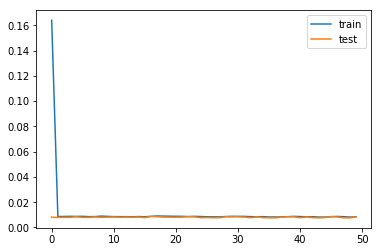

In [11]:
# Univariate LSTM time series model with one-step
model, scaler, train_X, train_y, test_X, test_y, names, target_original, fator_inverter_diff, index = execute_scenario(
    name = 'Univariate LSTM time series model with one-step', 
    time_steps = 3, 
    seq = 1, 
    vars_to_use_time_step = [1], 
    vars_to_use_time_seq = [1], 
    min_scale = 0, 
    max_scale = 1,
    n_train = 365*24
)

In [12]:
resultados = evaluate_model(model = model, 
                            scaler=scaler, 
                            test_X = test_X, 
                            X_names = names,
                            test_y = test_y,
                            n_train = 365*24,
                            target_original = target_original.values,
                            fator_inverter_diff = fator_inverter_diff,
                            index = index
                           )
resultados.head(5)

Test RMSE: 27.620


,var1(t-1),var1(t-2),var1(t-3),var1(t),yhat,target_original,rmse,lower_limit,upper_limit
date,,,,,,,,,
2011-01-02 03:00:00,-11.0,-5.0,36.0,-1.0,15.499306,19.0,27.620314,-12.121009,43.119620
2011-01-02 04:00:00,-1.0,-11.0,-5.0,-1.0,12.215846,18.0,27.620314,-15.404468,39.836161
2011-01-02 05:00:00,-1.0,-1.0,-11.0,-1.0,11.923798,17.0,27.620314,-15.696517,39.544112
2011-01-02 06:00:00,-1.0,-1.0,-1.0,-3.0,11.756952,14.0,27.620314,-15.863362,39.377266
2011-01-02 07:00:00,-3.0,-1.0,-1.0,0.0,8.386557,14.0,27.620314,-19.233757,36.006871


### Analisando os resultados por meio de graficos

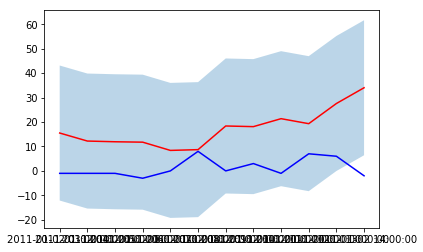

In [13]:
# Grafico de linha do valor real, previsto, intervalos
a = resultados.head(12)
pyplot.plot(a.index, a['var1(t)'], color='blue')
pyplot.plot(a.index, a['yhat'], color='red')
pyplot.fill_between(a.index, a['lower_limit'], a['upper_limit'], alpha=.3)
pyplot.show()

### Consideracoes finais e referencias
Vale a pena ressaltar que em um ambiente de producao teriamos que salvar nossos encoders, scalers e models em um arquivo.
Desta forma, para fazer previsoes teriamos que caregar estes objetos e apenas utiliza-los. Voce nao pode re-treinar os seus encoders, scalers (e obviamente models) nos seus dados de teste ou produtivos.

Referencias: 

* https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
* https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
* https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/